In [2]:
# Import needed libraries/packages
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_moons

In [3]:
# Set up the agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using: {device}")

Using: cpu


#### 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

In [4]:
from sklearn.model_selection import train_test_split

X, y = make_moons(
	n_samples=1000,
	random_state=42)

X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

print(X[:5], y[:5])

train_test_split = int(0.8 * len(X))
X_train, y_train = X[:train_test_split], y[:train_test_split]
X_test, y_test = X[train_test_split:], y[train_test_split:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

tensor([[ 0.0087,  0.3682],
        [ 0.9214, -0.4969],
        [ 0.9402, -0.4982],
        [ 0.4659, -0.3454],
        [-0.8504,  0.5261]]) tensor([1., 1., 1., 1., 0.])
torch.Size([800, 2]) torch.Size([800]) torch.Size([200, 2]) torch.Size([200])


#### 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.


In [5]:
# import nn
from torch import nn

# Let's create our model
class MoonModel(nn.Module):
	def __init__(self):
		super().__init__()
		self.layer1 = nn.Linear(in_features=2, out_features=20) # input leyer
		self.layer2 = nn.Linear(in_features=20, out_features=20) # hidden layer
		self.layer3 = nn.Linear(in_features=20, out_features=1) # output layer
		self.relu = nn.ReLU()

	def forward(self, x):
		return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = MoonModel().to(device)
print(f"Model: {model_0}")

Model: MoonModel(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


#### 3. Setup a binary classification compatible loss function and optimizer to use when training the model.


In [6]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [7]:
# Let's put some data
y_logits = model_0(X_test)[:5]
# y_logits.sigmoid()
y_logits.squeeze(), y_test[:5]

(tensor([-0.1994, -0.1642, -0.2028, -0.2130, -0.1621],
        grad_fn=<SqueezeBackward0>),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
from torchmetrics import Accuracy

# Let's build the training and testing loop 

metric_acc = Accuracy(num_classes=2, task='BINARY')

torch.manual_seed(42)

# Set up the epochs
epochs = 10001

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):

	# Train the model
	model_0.train()

	# Forward pass
	y_logits = model_0(X_train).squeeze()
	y_preds = torch.round(torch.sigmoid(y_logits))

	# Calculate the loss
	loss = loss_fn(y_logits, y_train)
	acc = metric_acc(y_preds, y_train)
	# Optimizer zero grad
	optimizer.zero_grad()

	# loss backwards
	loss.backward()

	# optimizer step
	optimizer.step()

	model_0.eval()
	with torch.inference_mode():
		# Forward pass
		test_logits = model_0(X_test).squeeze()
		test_preds = torch.round(torch.sigmoid(test_logits))
		test_acc = metric_acc(test_preds, y_test)
		# print(test_logits.shape, y_test.shape)
		# Calculate the loss
		test_loss = loss_fn(test_logits, y_test)

	if epoch % 1000 == 0:
		print(f"Epoch: {epoch} | Train Loss: {loss}, Accuracy: {(acc*100):.2f}% | Test Loss: {test_loss:.5f}, Accuracy: {(test_acc*100):.2f}%")


Epoch: 0 | Train Loss: 0.69905686378479, Accuracy: 49.88% | Test Loss: 0.69474, Accuracy: 50.50%
Epoch: 1000 | Train Loss: 0.009286475367844105, Accuracy: 100.00% | Test Loss: 0.01089, Accuracy: 100.00%
Epoch: 2000 | Train Loss: 0.002363688312470913, Accuracy: 100.00% | Test Loss: 0.00291, Accuracy: 100.00%
Epoch: 3000 | Train Loss: 0.0012307873694226146, Accuracy: 100.00% | Test Loss: 0.00155, Accuracy: 100.00%
Epoch: 4000 | Train Loss: 0.0008025462739169598, Accuracy: 100.00% | Test Loss: 0.00102, Accuracy: 100.00%
Epoch: 5000 | Train Loss: 0.0005844151019118726, Accuracy: 100.00% | Test Loss: 0.00075, Accuracy: 100.00%
Epoch: 6000 | Train Loss: 0.0004543077666312456, Accuracy: 100.00% | Test Loss: 0.00059, Accuracy: 100.00%
Epoch: 7000 | Train Loss: 0.0003687211428768933, Accuracy: 100.00% | Test Loss: 0.00048, Accuracy: 100.00%
Epoch: 8000 | Train Loss: 0.0003085072385147214, Accuracy: 100.00% | Test Loss: 0.00040, Accuracy: 100.00%
Epoch: 9000 | Train Loss: 0.0002641245082486421, 

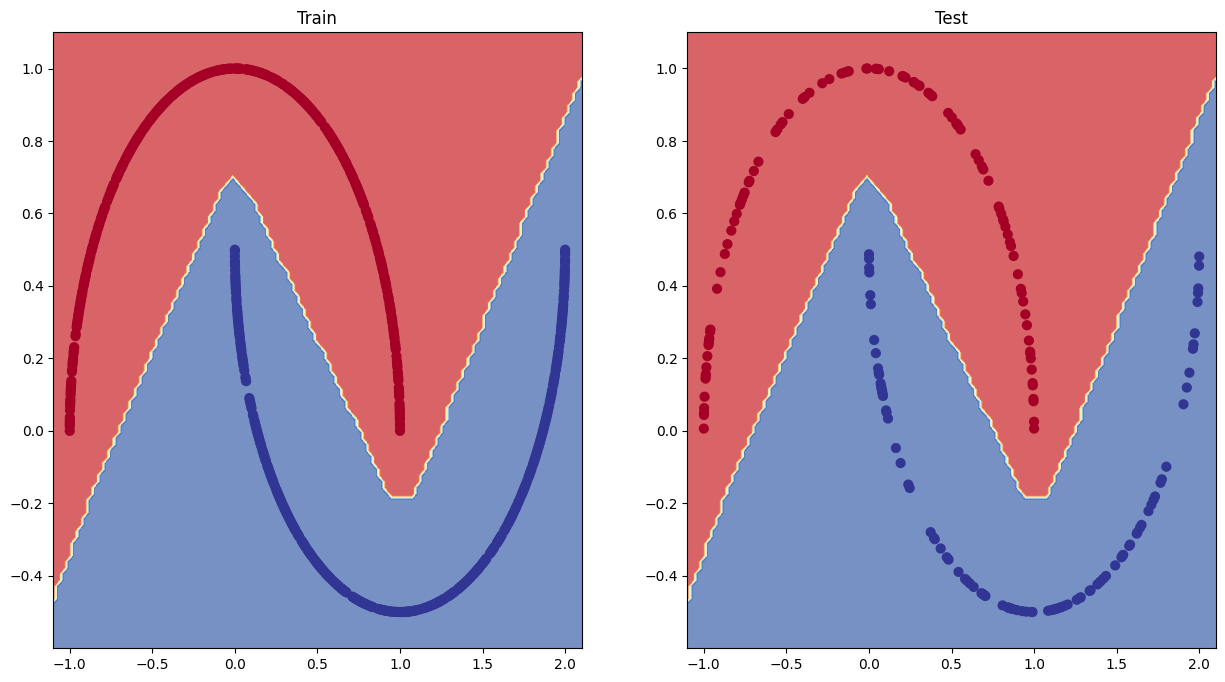

In [9]:
# Let' plot the data
from helper_functions import plot_decision_boundary


plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [10]:
# Let's make predictions

model_0.eval()
with torch.inference_mode():
	y_logits = model_0(X_test).squeeze()
	y_preds = torch.round(torch.sigmoid(y_logits))
	accuracy_0 = metric_acc(y_logits, y_test)

print(f"Here is the accuracy of the model we've trained: {(accuracy_0 * 100):.2f}%")
print(f"y_test: {y_test[:5]}")
print(f"y_logits: {y_logits[:5]}")
print(f"y_preds: {y_preds[:5]}")

Here is the accuracy of the model we've trained: 100.00%
y_test: tensor([1., 1., 1., 1., 0.])
y_logits: tensor([ 10.3560,  10.2575,  11.1940,   8.9179, -11.9979])
y_preds: tensor([1., 1., 1., 1., 0.])


#### 6.Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [11]:
def tanh(z):
	return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))

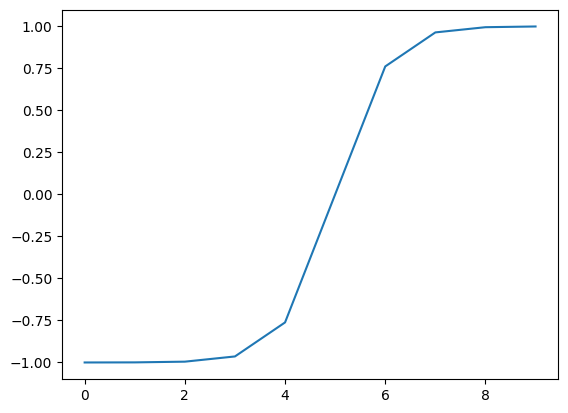

In [12]:
A = torch.arange(-5, 5, 1, dtype=torch.float32)

plt.plot(tanh(A))

#### 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

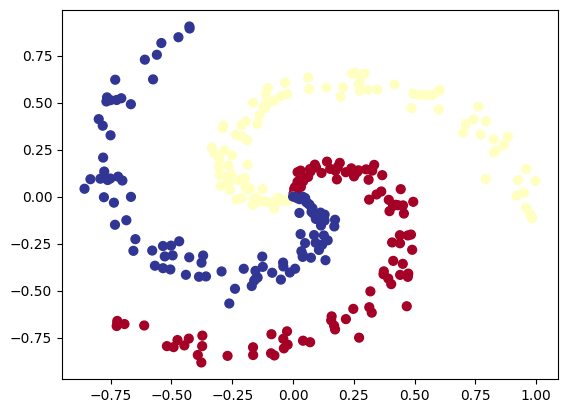

In [13]:
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()
     


In [14]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

In [15]:
print(X[:5], y[:5])

tensor([[0.0000, 0.0000],
        [0.0001, 0.0101],
        [0.0042, 0.0198],
        [0.0125, 0.0276],
        [0.0046, 0.0401]]) tensor([0, 0, 0, 0, 0])


In [16]:
# Now let's create train and test datasets


tt_split = int((len(X) * 0.8))
X_train, y_train = X[:tt_split], y[:tt_split]
X_test, y_test = X[tt_split:], y[tt_split:]

# Print out the shapes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([240, 2]) torch.Size([240]) torch.Size([60, 2]) torch.Size([60])


In [25]:
# Let's build the model 

class SpiralModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)  # Reduce neurons
        self.layer2 = nn.Linear(in_features=10, out_features=3)  # Combine layers
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer2(self.relu(self.layer1(x)))

# create an instance of model

model_1 = SpiralModelV0().to(device)
model_1

SpiralModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.01)

In [27]:
# Let's take a try and use our model

y_logits = model_1(X_test.to(device))[:5]
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)[0]
y_logits, y_preds, model_1(X_test.to(device)).squeeze()[:5]

(tensor([[ 0.2417, -0.4304, -0.1947],
         [ 0.2615, -0.4132, -0.1825],
         [ 0.2783, -0.3977, -0.1719],
         [ 0.2895, -0.3872, -0.1649],
         [ 0.2577, -0.4187, -0.1853]], grad_fn=<SliceBackward0>),
 tensor(0),
 tensor([[ 0.2417, -0.4304, -0.1947],
         [ 0.2615, -0.4132, -0.1825],
         [ 0.2783, -0.3977, -0.1719],
         [ 0.2895, -0.3872, -0.1649],
         [ 0.2577, -0.4187, -0.1853]], grad_fn=<SliceBackward0>))

In [28]:
y_logits.shape, y_train.shape, torch.tensor([[1, 2], [3, 4]]).shape


(torch.Size([5, 3]), torch.Size([240]), torch.Size([2, 2]))

In [32]:
# Build a training loop for the model
epochs = 1000

acc_fn = Accuracy(num_classes=3, task='multiclass')

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {(acc*100):.2f}% | Test loss: {test_loss:.2f}% Test acc: {(test_acc * 100):.2f}%")
     

		

Epoch: 0 | Loss: 0.01 Acc: 99.17% | Test loss: 438.56% Test acc: 5.00%
Epoch: 100 | Loss: 0.01 Acc: 99.17% | Test loss: 449.86% Test acc: 5.00%
Epoch: 200 | Loss: 0.01 Acc: 99.17% | Test loss: 460.50% Test acc: 5.00%
Epoch: 300 | Loss: 0.01 Acc: 99.17% | Test loss: 470.41% Test acc: 5.00%
Epoch: 400 | Loss: 0.01 Acc: 99.17% | Test loss: 479.87% Test acc: 5.00%
Epoch: 500 | Loss: 0.01 Acc: 99.17% | Test loss: 488.63% Test acc: 5.00%
Epoch: 600 | Loss: 0.01 Acc: 99.17% | Test loss: 497.06% Test acc: 5.00%
Epoch: 700 | Loss: 0.01 Acc: 99.17% | Test loss: 505.00% Test acc: 5.00%
Epoch: 800 | Loss: 0.01 Acc: 99.17% | Test loss: 512.61% Test acc: 5.00%
Epoch: 900 | Loss: 0.01 Acc: 99.17% | Test loss: 519.82% Test acc: 5.00%
